# Encoding reverse complement invariance

## Introduction

Base pair sequences can be encoded in a variety of different ways (*e.g.,* `TATAAGC...`). For machine learning applications, a commonly used encoding is a *one-hot* encoding: the same sequence above can be represented as the matrix
$$
\begin{array}{c}
A\\
C\\
G\\
T
\end{array}
\overset{T\quad A\quad T\quad A\quad A\quad G\quad C}{\left[ \begin{array}{ccccccc}
0 & 1 & 0 & 1 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 \\
1 & 0 & 1 & 0 & 0 & 0 & 0
\end{array}\right]}
$$

However, we could equally well represent this sequence using complex numbers. For $j \geq 1$, let $z_j \in \mathbb{C}$ encode our *belief* about the identity of the $j$th base pair in the following way. Enforce $|z_j| \leq 1$ and identify $z_j = 1$ as full belief that $z_j = \mathtt{A}$; $z_j = -1$ with $z_j = \mathtt{T}$; $z_j = i$ with $z_j = \mathtt{C}$; and $z_j = -i$ with $z_j = \mathtt{G}$. Then we can represent the same sequence as above in the following way:
$$
\vec x := \overset{T \quad\, A \quad\, T \quad\, A \quad\, A \quad\, G \quad\, C}{\left[\begin{array}{ccccccc}
-1 & 1 & -1 & 1 & 1 & -i & i
\end{array}\right]}
$$

Note that intermediate values (*i.e.,* those that are not equal to $1, -1, i, -1$) can be interpreted still as a *strength of belief* about the identity of that base pair. For example, $(1+i)/\sqrt{2}$ can be interpreted as an equal belief that the identity of that base pair is either `A` or `C`. One thing we lose is the ability to tell the difference between "maybe A or T but not C or G" and "equal belief for A, C, G, T". We hope this may not pose a problem, since it is typically very unlikely in real life for A and T to be confused, whereas it is relatively more likely for T and C to be confused or A and G (due to the structure and size of the aromatic rings that compose them). 

## Reverse Complement

The reverse complement of a sequence should be identified by a neural network in the same way as the original strand (due to the way that DNA is built). 

The reverse complement of `TATAAGC` is `GCTTATA`. This would be encoded by the sequence 
$$
\vec x_{\mathrm{RC}} := \overset{G \quad\,\, C \quad\,\, T \quad\,\, T \quad\,\, A \quad\,\, T \quad\,\, A}{\left[\begin{array}{ccccccc}
-i & i & -1 & -1 & 1 & -1 & 1
%-1 & 1 & -1 & 1 & 1 & -i & i
\end{array}\right]}
$$

## Invariance under convolution

We'd like a sequence and its reverse complement to be invariant under convolution so that when we inject a sequence into a neural network, we can expect it to behave the same way as when we inject its reverse complement. 

First, define the exchange matrix $J_n \in \mathbb{R}^{n\times n}$ by
$$
(J_n)_{ij} := \begin{cases}
1 & j = n - i + 1\\
0 & \text{otherwise}
\end{cases}
$$
so that, for example,
$$
J_3 := 
\left[\begin{array}{rrr}
0 & 0 & 1\\
0 & 1 & 0\\
1 & 0 & 0 
\end{array} \right]
$$

Next, define $K_n := -J_n$. Note that the sequence $\vec x$ can be transformed into the sequence $\vec x_{\mathrm{RC}}$ by left matrix multiplication with $K_n$:

$$
\vec x_{\mathrm{RC}} = K_n \vec x
$$

In particular, if the first layer of a neural network is given by 
$$
h(\vec x) = \sigma ( W \vec x + b ) 
$$
for an activation function $\sigma$, convolutional matrix $W$ and bias $b$, then we would like to demand that 
$$
\sigma (W \vec x + b)  = h(\vec x) = h(\vec x_{\mathrm{RC}}) = \sigma(W K_n \vec x + b)
$$

Writing $W = (w_{i,j})_{i,j}$, this constraint is equivalent to the demand that 
$$
W = W K_n
\quad \iff \quad 
w_{i,j} = -w_{i, n-j+1}
$$

## Next steps: Viability and interpretability

It remains to be determined if this particular architecture is too strict a constraint. Typically, convolutional matrices are in some way structured so that they can carry out the convolution... Would imposing this type of parameter pairing destroy that convolutional structure? 

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

import keras.backend as K
from keras.layers import Conv1D, Dense, Flatten, Input, GlobalMaxPool1D, MaxPool1D, Reshape
from keras.models import Model

from keras.utils import to_categorical

Using TensorFlow backend.


### Helper functions

In [3]:
bp_row_dict = {'A': 0, 'T': 3, 
               'C': 1, 'G': 2}
row_bp_dict = {0: 'A', 1: 'C',
               2: 'G', 3: 'T'}
def _basePairToRow(bp):
    return bp_row_dict[bp]
def _rowToBasePair(row):
    return row_bp_dict[row]

In [4]:
rc_dict = {'A': 'T', 'T': 'A',                
           'C': 'G', 'G': 'C'}
def _reverseComplementOfBasePair(bp):
    return rc_dict[bp]

In [5]:
"""
seq -> OH
seq -> Complex
OH -> Complex
OH -> seq

"""
def seqToOneHot(seq):
    # Returns N-by-4 onehot encoding of sequence
    from keras.utils import to_categorical
    return to_categorical(list(map(_basePairToRow, seq)), num_classes=4)


def seqToComplex(seq):
    return oneHotToComplex(seqToOneHot(seq))


def idxToComplex(idx):
    cplx = np.zeros((len(idx), 2))
    cplx[idx < 2, idx[idx < 2]] = 1
    cplx[idx>1, idx[idx > 1]-3] = -1
    return cplx


def oneHotToComplex(oh):
    Xr = oh[:, 0] - oh[:, 3] # A - T
    Xi = oh[:, 1] - oh[:, 2] # C - G
    Xabs = np.sqrt(Xr**2 + Xi**2)
    Xr = Xr / Xabs
    Xi = Xi / Xabs
    return np.column_stack((Xr, Xi))


def oneHotToSeq(oh):
    rows = np.argmax(oh, axis=-1)
    return ''.join(['ACGT'[j] for j in rows])


def cplxToOneHot(cplx):
    AC = cplx[cplx > 0]
    TG = -cplx[cplx < 0]
    return np.column_stack((AC, TG))


def cplxToSeq(cplx):
    oneHotToSeq(cplxToOneHot(cplx))
    return


def reverseComplementOfComplex(cplx):
    return -cplx[::-1, :]


def reverseComplementOfSeq(seq):
    ''.join(map(_reverseComplementOfBasePair, seq))

    
def reverseComplementOfOneHot(oh):
    return oh[::-1, ::-1]

### Set up training set

In [6]:
n_samples = 100000
sample_length = 32

In [7]:
rowNumbers = np.random.randint(4, size=n_samples*sample_length).reshape(n_samples, sample_length)

In [8]:
X = np.concatenate([idxToComplex(nums)[np.newaxis, ...] for nums in rowNumbers])

In [9]:
# Random labels
y = (np.random.randn(n_samples) > 0).astype(int)

### Build neural network

In [10]:
sess = tf.Session()
K.set_session(sess)

In [11]:
input_seq = Input(shape=(32, 2,), dtype='float32')

In [12]:
x = Conv1D(16, 8, activation='relu')(input_seq)
x = GlobalMaxPool1D()(x)
x = Reshape((16,1))(x)
x = Conv1D(16, 8, activation='relu', padding='same')(x)
x = MaxPool1D()(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_seq, outputs=x)

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 2)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 16)            272       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 1)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 16)            144       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

In [14]:
model.compile('adagrad', 'binary_crossentropy', metrics=['accuracy', 'mse'])

In [15]:
model.fit(x=X, y=y, epochs=30, validation_split=.2, verbose=2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/30
5s - loss: 0.6934 - acc: 0.5009 - mean_squared_error: 0.2501 - val_loss: 0.6932 - val_acc: 0.5012 - val_mean_squared_error: 0.2500
Epoch 2/30
5s - loss: 0.6932 - acc: 0.5018 - mean_squared_error: 0.2500 - val_loss: 0.6932 - val_acc: 0.4958 - val_mean_squared_error: 0.2500
Epoch 3/30
5s - loss: 0.6931 - acc: 0.5044 - mean_squared_error: 0.2500 - val_loss: 0.6932 - val_acc: 0.4998 - val_mean_squared_error: 0.2501
Epoch 4/30
5s - loss: 0.6930 - acc: 0.5067 - mean_squared_error: 0.2499 - val_loss: 0.6932 - val_acc: 0.4984 - val_mean_squared_error: 0.2500
Epoch 5/30
5s - loss: 0.6929 - acc: 0.5094 - mean_squared_error: 0.2499 - val_loss: 0.6934 - val_acc: 0.5017 - val_mean_squared_error: 0.2501
Epoch 6/30
5s - loss: 0.6929 - acc: 0.5098 - mean_squared_error: 0.2499 - val_loss: 0.6933 - val_acc: 0.4971 - val_mean_squared_error: 0.2501
Epoch 7/30
5s - loss: 0.6928 - acc: 0.5132 - mean_squared_error: 0.2498 - val_loss: 0.6933 - val_a

### Analyze weights and responses

In [16]:
W = model.get_weights()

In [39]:
def stackFilters(w):
    return np.column_stack(w.transpose((2,0,1)))

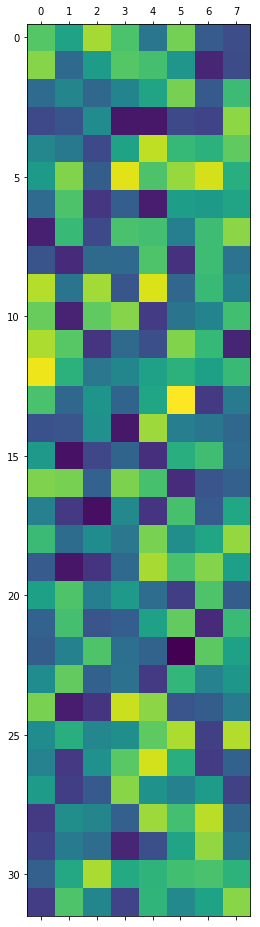

In [41]:
plt.matshow(stackFilters(W[0]).T)

In [54]:
X_rc = np.concatenate([reverseComplementOfComplex(x)[np.newaxis, ...] for x in X])

In [58]:
y_rc_proba = model.predict(X_rc)

In [56]:
from sklearn.metrics import accuracy_score

In [60]:
y_rc_pred = (y_rc_proba > 0).astype(int) - (y_rc_proba < 0).astype(int)

In [61]:
accuracy_score(y, y_rc_pred)

0.49980999999999998

### Now to make the parameter tying happen...

Goal: write a keras constraint function that takes care of the weight tying within the same layer. 

## Fancier possibilities

In looking for how to handle complex variables in keras, I came across [this paper](https://arxiv.org/pdf/1612.04642.pdf) that defines Harmonic Networks. Associated code is [available here](https://github.com/deworrall92/harmonicConvolutions). It appears at a cursory glance as though such networks could be useful for invariance to reverse complement. 